## <b><font color='darkblue'>Preface</font></b>
([source](https://learn.deeplearning.ai/courses/evaluating-ai-agents/lesson/pag5y/lab-1:-building-your-agent))

![course outline](images/course_outline.jpg)

In [29]:
from datetime import datetime

### <b><font color='darkgreen'>Evaluation in the time of LLM</font></b>
([source](https://learn.deeplearning.ai/courses/evaluating-ai-agents/lesson/gz8ys/evaluation-in-the-time-of-llms))

![tools](images/tool_4_evaluation.jpg )

### <b><font color='darkgreen'>Decomposing Agent</font></b>
([source](https://learn.deeplearning.ai/courses/evaluating-ai-agents/lesson/hvoxa/decomposing-agents))

![Agent components](images/agent_components.jpg)

## <b><font color='darkblue'>Lab1 - Build Your Agent</font></b>
([source](https://learn.deeplearning.ai/courses/evaluating-ai-agents/lesson/pag5y/lab-1:-building-your-agent))

### <b><font color='darkgreen'>Install the Python SDK</font></b>


In [5]:
#!pip install -U -q langchain-google-genai
#!pip install -U -q google-generativeai

In [6]:
!pip freeze | grep 'google-generativeai'

google-generativeai==0.8.5


### <b><font color='darkgreen'>Configure SDK and API Key</font></b>

In [8]:
import google.generativeai as genai
import os
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv(os.path.expanduser('~/.env'))) # read local .env file
genai.configure(api_key=os.environ['GOOGLE_API_KEY'])

### <b><font color='darkgreen'>ReAct agent from scratch with Gemini 2.5 and LangGraph</font></b>
([source](https://ai.google.dev/gemini-api/docs/langgraph-example)) <font size='3ptx'>**[LangGraph](https://www.langchain.com/langgraph) is a framework for building stateful LLM applications, making it a good choice for constructing ReAct (Reasoning and Acting) Agents.**</font>

<b>ReAct agents combine LLM reasoning with action execution.</b> They iteratively think, use tools, and act on observations to achieve user goals, dynamically adapting their approach. Introduced in "[ReAct: Synergizing Reasoning and Acting in Language Models](https://arxiv.org/abs/2210.03629)" (2023), this pattern tries to mirror human-like, flexible problem-solving over rigid workflows.

While [**LangGraph**](https://www.langchain.com/langgraph) offers a prebuilt ReAct agent ([create_react_agent](https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent)), it shines when you need more control and customization for your ReAct implementations.

[**LangGraph**](https://www.langchain.com/langgraph) models agents as graphs using three key components:
* **State**: Shared data structure (typically `TypedDict` or Pydantic `BaseModel`) representing the application's current snapshot.
* **Nodes**: Encodes logic of your agents. They receive the current `State` as input, perform some computation or side-effect, and return an updated `State`, such as LLM calls or tool calls.
* **Edges**: Define the next `Node` to execute based on the current `State`, allowing for conditional logic and fixed transitions.

Below will use pip to install necessary packages:

In [10]:
#!pip install langgraph langchain-google-genai geopy requests

**To better understand how to implement a ReAct agent using [LangGraph](https://www.langchain.com/langgraph), let's walk through a practical example**. You will create a simple agent whose goal is to use a tool to find the current weather for a specified location.

For this weather agent, its `State` will need to maintain the ongoing conversation history (as a list of messages) and a counter for the number of steps taken to further illustrate state management.

**[LangGraph](https://www.langchain.com/langgraph)** provides a convenient helper, **`add_messages`, for updating message lists in the state. It functions as a reducer, meaning it takes the current list and new messages, then returns a combined list**. It smartly handles updates by message ID and defaults to an "append-only" behavior for new, unique messages.

In [30]:
from typing import Annotated,Sequence, TypedDict

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages # helper function to add messages to the state


def today():
    return datetime.today().strftime('%Y-%m-%d')


class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

Next, we define the weather tool.

In [14]:
from langchain_core.tools import tool
from geopy.geocoders import Nominatim
from pydantic import BaseModel, Field
import requests

geolocator = Nominatim(user_agent="weather-app")

class SearchInput(BaseModel):
    location:str = Field(description="The city and state, e.g., San Francisco")
    date:str = Field(description="the forecasting date for when to get the weather format (yyyy-mm-dd)")


@tool("get_weather_forecast", args_schema=SearchInput, return_direct=True)
def get_weather_forecast(location: str, date: str):
    """Retrieves the weather using Open-Meteo API for a given location (city) and a date (yyyy-mm-dd).
    
    Returns a list dictionary with the time and temperature for each hour."""
    location = geolocator.geocode(location)
    if location:
        try:
            response = requests.get(
                f"https://api.open-meteo.com/v1/forecast?latitude={location.latitude}&"
                f"longitude={location.longitude}&hourly=temperature_2m&start_date={date}&end_date={date}")
            data = response.json()
            return {
                time: temp
                for time, temp in zip(data["hourly"]["time"], data["hourly"]["temperature_2m"])
            }
        except Exception as e:
            return {"error": str(e)}
    else:
        return {"error": "Location not found"}


tools = [get_weather_forecast]

Next, you initialize your model and bind the tools to the model:

In [16]:
from datetime import datetime
from langchain_google_genai import ChatGoogleGenerativeAI

# Create LLM class
llm = ChatGoogleGenerativeAI(
    model= "gemini-2.5-pro",
    temperature=1.0,
    max_retries=2)

# Bind tools to the model
model = llm.bind_tools([get_weather_forecast])

In [21]:
query = f"What is the weather in Berlin on {today()}?"
print(query)

What is the weather in Berlin on 2025-07-02?


In [22]:
# Test the model with tools
res=model.invoke(query)

In [25]:
print(res)

content='' additional_kwargs={'function_call': {'name': 'get_weather_forecast', 'arguments': '{"date": "2025-07-02", "location": "Berlin"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-pro', 'safety_ratings': []} id='run--75360ffb-a3ce-44c3-b822-c93498739c21-0' tool_calls=[{'name': 'get_weather_forecast', 'args': {'date': '2025-07-02', 'location': 'Berlin'}, 'id': 'b0a449c8-9d8e-4e8b-922c-647284f4c717', 'type': 'tool_call'}]


**The last step before you can run your agent is to define your nodes and edges**. In this example, you have two nodes and one edge. - `call_tool` node that executes your tool method. LangGraph has a prebuilt node for this called [**ToolNode**](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/#toolnode). - `call_model` node that uses the `model_with_tools` to call the model. - `should_continue` edge that decides whether to call the tool or the model.

The number of nodes and edges is not fixed. You can add as many nodes and edges as you want to your graph. For example, you could add a node for adding structured output or a self-verification/reflection node to check the model output before calling the tool or the model.

In [24]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableConfig

tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
        
    # default to continue
    return "continue"

Now you have all the components to build your agent. Let's put them together.

In [27]:
from langgraph.graph import StateGraph, END

# Define a new graph with our state
workflow = StateGraph(AgentState)

# 1. Add our nodes 
workflow.add_node("llm", call_model)
workflow.add_node("tools",  call_tool)

# 2. Set the entrypoint as `agent`, this is the first node called
workflow.set_entry_point("llm")

# 3. Add a conditional edge after the `llm` node is called.
workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `tools` is called, `llm` node is called next.
workflow.add_edge("tools", "llm")

# Now we can compile and visualize our graph
graph = workflow.compile()

You can visualize your graph using the [`draw_mermaid_png`](https://api.python.langchain.com/en/latest/core/runnables/langchain_core.runnables.graph_mermaid.draw_mermaid_png.html) method.

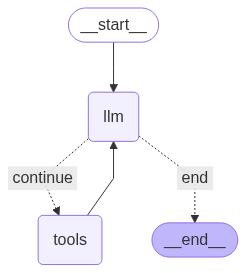

In [28]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

Now let's run the agent:

In [32]:
# Create our initial message dictionary
inputs = {
    "messages": [
        ("user", f"What is the weather in city Taipei from Taiwan on {today()}?")]}

# call our graph with streaming to see the steps
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()

================================ Human Message =================================

What is the weather in city Taipei from Taiwan on 2025-07-04?
================================== Ai Message ==================================
Tool Calls:
  get_weather_forecast (d654ba7d-80f4-407b-898b-b15527b8a01b)
 Call ID: d654ba7d-80f4-407b-898b-b15527b8a01b
  Args:
    date: 2025-07-04
    location: Taipei, Taiwan
================================= Tool Message =================================
Name: get_weather_forecast

{'2025-07-04T00:00': 30.8, '2025-07-04T01:00': 32.3, '2025-07-04T02:00': 33.8, '2025-07-04T03:00': 34.8, '2025-07-04T04:00': 35.6, '2025-07-04T05:00': 35.8, '2025-07-04T06:00': 35.2, '2025-07-04T07:00': 34.7, '2025-07-04T08:00': 34.4, '2025-07-04T09:00': 33.4, '2025-07-04T10:00': 32.2, '2025-07-04T11:00': 30.8, '2025-07-04T12:00': 29.7, '2025-07-04T13:00': 29.1, '2025-07-04T14:00': 28.5, '2025-07-04T15:00': 28.0, '2025-07-04T16:00': 27.7, '2025-07-04T17:00': 27.6, '2025-07-04T18:00'

### <b><font color='darkgreen'>SQL agent</font></b>
Now we are going to build an agent to deal with SQL with working flow as below:

![SQL agent](images/lab1_agent_sql_working_diagram.png)

#### <b>Tool 1 `lookup_sales_data`: Database Lookup</b>

In [37]:
import pandas as pd
import json
import duckdb

from pydantic import BaseModel, Field
from IPython.display import Markdown

# define the path to the transactional data
TRANSACTION_DATA_FILE_PATH = 'data/Store_Sales_Price_Elasticity_Promotions_Data.parquet'

This database lookup tool works using three steps.

![generate db steps](images/lab1_generate_db.png)

1. First, it creates the SQL table from a local file, if not already done.
2. Second, it translates the original prompt into an sql query (using an LLM call).
3. Finally, it runs that query against the database.

In [38]:
# prompt template for step 2 of tool 1
SQL_GENERATION_PROMPT = """
Generate an SQL query based on a prompt. Do not reply with anything besides the SQL query.
The prompt is: {prompt}

The available columns are: {columns}
The table name is: {table_name}
"""

In [45]:
# code for step 2 of tool 1
def generate_sql_query(prompt: str, columns: list, table_name: str, chat_model=llm) -> str:
    """Generate an SQL query based on a prompt"""
    formatted_prompt = SQL_GENERATION_PROMPT.format(prompt=prompt, 
                                                    columns=columns, 
                                                    table_name=table_name)

    response = chat_model.invoke(formatted_prompt)
    
    return response.content

Next, let's load in our testing data and explore it:

In [47]:
df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)

In [48]:
df.head()

,Store_Number,SKU_Coded,Product_Class_Code,Sold_Date,Qty_Sold,Total_Sale_Value,On_Promo
0,1320,6172800,22875,2021-11-02,3,56.849998,0
1,2310,6172800,22875,2021-11-03,1,18.950001,0
2,3080,6172800,22875,2021-11-03,1,18.950001,0
3,2310,6172800,22875,2021-11-06,1,18.950001,0
4,4840,6172800,22875,2021-11-07,1,18.950001,0


So below function will try to compose the SQL from given `prompt` and return the querying result:

In [64]:
# code for tool 1
class LookupSalesDataInput(BaseModel):
    prompt:str = Field(description="The unchanged prompt that the user provided.")


@tool("lookup_sales_data", args_schema=LookupSalesDataInput)
def lookup_sales_data(prompt: str) -> str:
    """Look up data from Store Sales Price Elasticity Promotions dataset."""
    try:

        # define the table name
        table_name = "sales"
        
        # step 1: read the parquet file into a DuckDB table
        df = pd.read_parquet(TRANSACTION_DATA_FILE_PATH)
        duckdb.sql(f"CREATE TABLE IF NOT EXISTS {table_name} AS SELECT * FROM df")

        # step 2: generate the SQL code
        sql_query = generate_sql_query(prompt, df.columns, table_name)
        # clean the response to make sure it only includes the SQL code
        sql_query = sql_query.strip()
        sql_query = sql_query.replace("```sql", "").replace("```", "")
        
        # step 3: execute the SQL query
        result = duckdb.sql(sql_query).df()
        
        return result.to_string()
    except Exception as e:
        return f"Error accessing data: {str(e)}"

Great! Now let's test the first tool and make sure it worked correctly.

In [50]:
example_data = lookup_sales_data("Show me all the sales for store 1320 on November 1st, 2021")
print(example_data)

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200               22975 2021-11-01         2         99.980003         0
3           1320    6176800               22800 2021-11-01         1         14.970000         0
4           1320    6177250               22975 2021-11-01         1          6.890000         0
5           1320    6177300               22800 2021-11-01         1          9.990000         0
6           1320    6177350               22800 2021-11-01         2         16.980000         0
7           1320    6177700               22875 2021-11-01         1          3.190000         0
8           1320    6178000               22875 2021-11-01         2          6.380000         0
9           1320    6178250   

#### <b>Tool 2 `analyze_sales_data`: Data Analysis</b>
The second tool can analyze the returned data and display conclusions to users:

![data analysis](images/lab1_data_analysis.png)

In [51]:
# Construct prompt based on analysis type and data subset
DATA_ANALYSIS_PROMPT = """
Analyze the following data: {data}
Your job is to answer the following question: {prompt}
"""

In [70]:
# code for tool 2
class AnalyzeSalesDataInput(BaseModel):
    prompt:str = Field(description="The lookup_sales_data tool's output.")
    data: str = Field(description="The unchanged prompt that the user provided.")


@tool("analyze_sales_data", args_schema=AnalyzeSalesDataInput, return_direct=False)
def analyze_sales_data(prompt: str, data: str, chat_model=llm) -> str:
    """Analyze sales data to extract insights"""
    formatted_prompt = DATA_ANALYSIS_PROMPT.format(data=data, prompt=prompt)

    response = chat_model.invoke(formatted_prompt)
    
    analysis = response.content
    return analysis if analysis else "No analysis could be generated"

This tool is relatively simple, but let's still test it out to be sure things are working correctly:

In [53]:
print(analyze_sales_data(prompt="what trends do you see in this data", 
                         data=example_data))

Of course. Based on the provided data snippet, here is an analysis of the observable trends.

### Executive Summary

The data represents a snapshot of 30 sales transactions from a **single store (1320)** on a **single day (November 1, 2021)**. The key trends observed are related to product class performance, price points, and the minimal use of promotions on this particular day. **Product Class 22975** generated the most revenue, driven by a high-priced item, while **Product Class 22800** sold the highest number of units. Promotions were nearly non-existent, with only one item marked as on sale, which appears to have a lower unit price than a similar non-promo item.

---

### Detailed Trend Analysis

#### 1. Data Scope and Limitations
It is crucial to note that this analysis is based on a very limited sample:
*   **Single Store:** All transactions are for `Store_Number` 1320. No comparisons between stores can be made.
*   **Single Day:** All transactions occurred on `Sold_Date` 2021-11

#### <b>Tool 3 `generate_visualization`: Data Visualization</b>
The third tool generates python code to create the requested graphs from the returned data of the first tool. It consists of two steps:

![generate charts](images/lab1_generate_charts.png)

1. First, it creates the chart configuration: chart type, title, data, lables for x-axis and y-axis (using an LLM call).
2. Second, it generates the python code based on the chart configuration of the first step (using an LLM call).

In [54]:
# prompt template for step 1 of tool 3
CHART_CONFIGURATION_PROMPT = """
Generate a chart configuration based on this data: {data}
The goal is to show: {visualization_goal}
"""

In [55]:
# class defining the response format of step 1 of tool 3
class VisualizationConfig(BaseModel):
    chart_type: str = Field(..., description="Type of chart to generate")
    x_axis: str = Field(..., description="Name of the x-axis column")
    y_axis: str = Field(..., description="Name of the y-axis column")
    title: str = Field(..., description="Title of the chart")

In [56]:
# code for step 1 of tool 3
def extract_chart_config(data: str, visualization_goal: str, chat_model=llm) -> dict:
    """Generate chart visualization configuration
    
    Args:
        data: String containing the data to visualize
        visualization_goal: Description of what the visualization should show
        
    Returns:
        Dictionary containing line chart configuration
    """
    formatted_prompt = CHART_CONFIGURATION_PROMPT.format(data=data,
                                                         visualization_goal=visualization_goal)

    structured_chat_model = chat_model.with_structured_output(VisualizationConfig)
    response = structured_chat_model.invoke(formatted_prompt)
    
    try:
        # Extract axis and title info from response
        content = response.content
        
        # Return structured chart config
        return {
            "chart_type": content.chart_type,
            "x_axis": content.x_axis,
            "y_axis": content.y_axis,
            "title": content.title,
            "data": data
        }
    except Exception:
        return {
            "chart_type": "line", 
            "x_axis": "date",
            "y_axis": "value",
            "title": visualization_goal,
            "data": data
        }

In [57]:
# prompt template for step 2 of tool 3
CREATE_CHART_PROMPT = """
Write python code to create a chart based on the following configuration.
Only return the code, no other text.
config: {config}
"""

In [59]:
# code for step 2 of tool 3
def create_chart(config: dict, chat_model=llm) -> str:
    """Create a chart based on the configuration"""
    formatted_prompt = CREATE_CHART_PROMPT.format(config=config)
    
    response = chat_model.invoke(formatted_prompt)
    
    code = response.content
    code = code.replace("```python", "").replace("```", "")
    code = code.strip()
    
    return code

In [68]:
# code for tool 3
class GenerateVisualInput(BaseModel):
    data: str = Field(..., description="The lookup_sales_data tool's output.")
    visualization_goal: str = Field(..., description="The goal of the visualization.")


@tool("generate_visualization", args_schema=GenerateVisualInput, return_direct=False)
def generate_visualization(data: str, visualization_goal: str) -> str:
    """Generate Python code to create data visualizations."""
    config = extract_chart_config(data, visualization_goal)
    code = create_chart(config)
    return code

Great, now let's try the third tool out:

In [61]:
code = generate_visualization(
    example_data, 
    "A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.")

print(code)

import pandas as pd
import matplotlib.pyplot as plt
import io

config = {'chart_type': 'line', 'x_axis': 'date', 'y_axis': 'value', 'title': 'A bar chart of sales by product SKU. Put the product SKU on the x-axis and the sales on the y-axis.', 'data': '    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo\n0           1320    6173050               22875 2021-11-01         1          4.990000         0\n1           1320    6174250               22875 2021-11-01         1          0.890000         0\n2           1320    6176200               22975 2021-11-01         2         99.980003         0\n3           1320    6176800               22800 2021-11-01         1         14.970000         0\n4           1320    6177250               22975 2021-11-01         1          6.890000         0\n5           1320    6177300               22800 2021-11-01         1          9.990000         0\n6           1320    6177350               22800 2021-11-01   

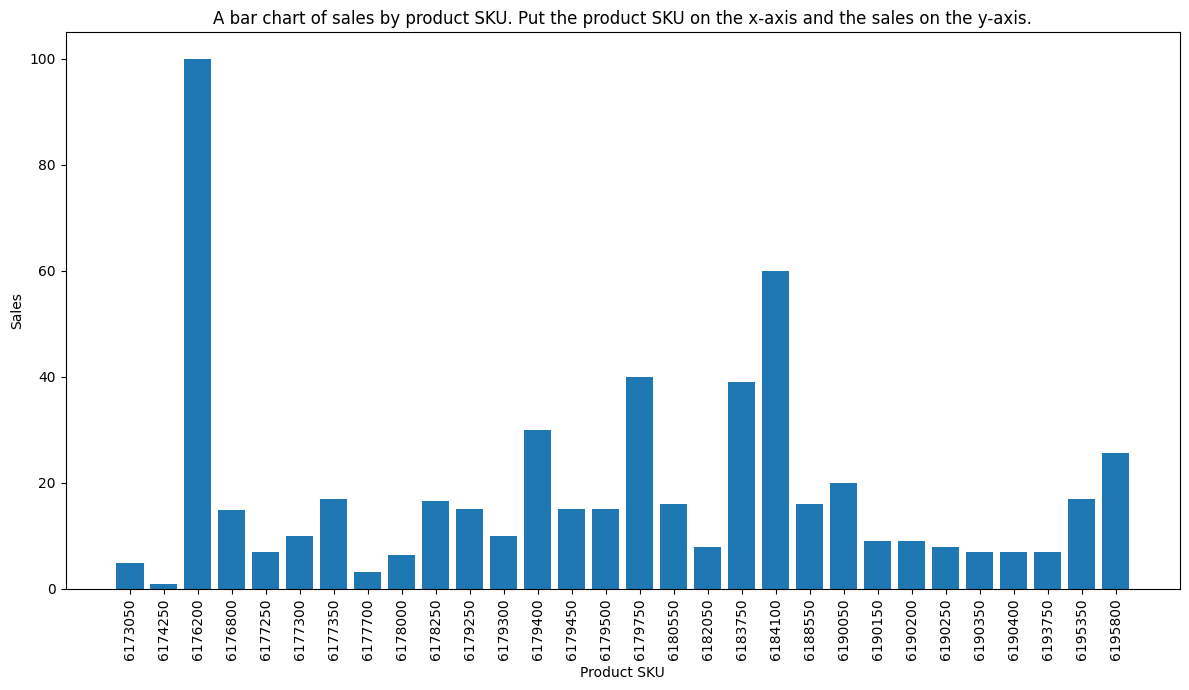

In [63]:
exec(code)

#### <b>Defining the Router</b>
Now that all of the tools are defined, you can create the router. The router will take the original user input, and is responsible for calling any tools. <b>After each tool call is completed, the agent will return to router to determine whether another tool should be called</b>.

The router is composed of a main loop method, and a method to handle the tool calls that you get back from the model:

![Router logic](images/lab1_router_logic.png)

In [69]:
# Create LLM class
llm_sql = ChatGoogleGenerativeAI(
    model= "gemini-2.5-pro",
    temperature=1.0,
    max_retries=2)

In [72]:
# Bind tools to the model
sql_tools = [lookup_sales_data, analyze_sales_data, generate_visualization]
model = llm_sql.bind_tools(sql_tools)

In [75]:
sql_tools_by_name = {tool.name: tool for tool in sql_tools}

# Define our tool node
def call_sql_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = sql_tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_sql_model(
    state: AgentState,
    config: RunnableConfig,
):
    # Invoke the model with the system prompt and the messages
    response = model.invoke(state["messages"], config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}


# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
        
    # default to continue
    return "continue"

In [77]:
# Define a new graph with our state
sql_workflow = StateGraph(AgentState)

# 1. Add our nodes 
sql_workflow.add_node("llm", call_sql_model)
sql_workflow.add_node("sql_tools",  call_sql_tool)

# 2. Set the entrypoint as `agent`, this is the first node called
sql_workflow.set_entry_point("llm")

# 3. Add a conditional edge after the `llm` node is called.
sql_workflow.add_conditional_edges(
    # Edge is used after the `llm` node is called.
    "llm",
    # The function that will determine which node is called next.
    should_continue,
    # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
    # END is a special node marking that the graph is finish.
    {
        # If `tools`, then we call the tool node.
        "continue": "sql_tools",
        # Otherwise we finish.
        "end": END,
    },
)
# 4. Add a normal edge after `sql_tools` is called, `llm` node is called next.
sql_workflow.add_edge("sql_tools", "llm")

# Now we can compile and visualize our graph
sql_graph = sql_workflow.compile()

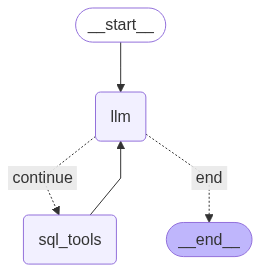

In [78]:
display(Image(sql_graph.get_graph().draw_mermaid_png()))

Let's test the SQL workflow:

In [87]:
from langchain_core.messages import HumanMessage, SystemMessage

SYSTEM_PROMPT = """
You are a helpful assistant that can answer questions about the Store Sales Price Elasticity Promotions dataset.
For any request to generate the code, please return the generated code only without anything else.
"""

In [86]:
# Create our initial message dictionary
#messages = [
#    SystemMessage(SYSTEM_PROMPT),
#    HumanMessage("Show me all the sales for store 1320 on November 1st, 2021."),
#]

inputs = {
    "messages": [
        ("system", SYSTEM_PROMPT),
        ("user",
         (
             "For all the sales for store 1320 on November 1st, 2021, Generate code for a bar chart of sales by product SKU."
             "Put the product SKU on the x-axis and the sales on the y-axis. Please return the generated code only.")
        )]}

# call our graph with streaming to see the steps
final_message_content = None
for state in graph.stream(inputs, stream_mode="values"):
    last_message = state["messages"][-1]
    last_message.pretty_print()
    final_message_content = last_message.content

================================ Human Message =================================

For all the sales for store 1320 on November 1st, 2021, Generate code for a bar chart of sales by product SKU.Put the product SKU on the x-axis and the sales on the y-axis. Please return the generated code only.
================================== Ai Message ==================================
Tool Calls:
  lookup_sales_data (e143aef6-0dcd-4e68-b95e-7583388abdcc)
 Call ID: e143aef6-0dcd-4e68-b95e-7583388abdcc
  Args:
    prompt: For all the sales for store 1320 on November 1st, 2021.
================================= Tool Message =================================
Name: lookup_sales_data

    Store_Number  SKU_Coded  Product_Class_Code  Sold_Date  Qty_Sold  Total_Sale_Value  On_Promo
0           1320    6173050               22875 2021-11-01         1          4.990000         0
1           1320    6174250               22875 2021-11-01         1          0.890000         0
2           1320    6176200       

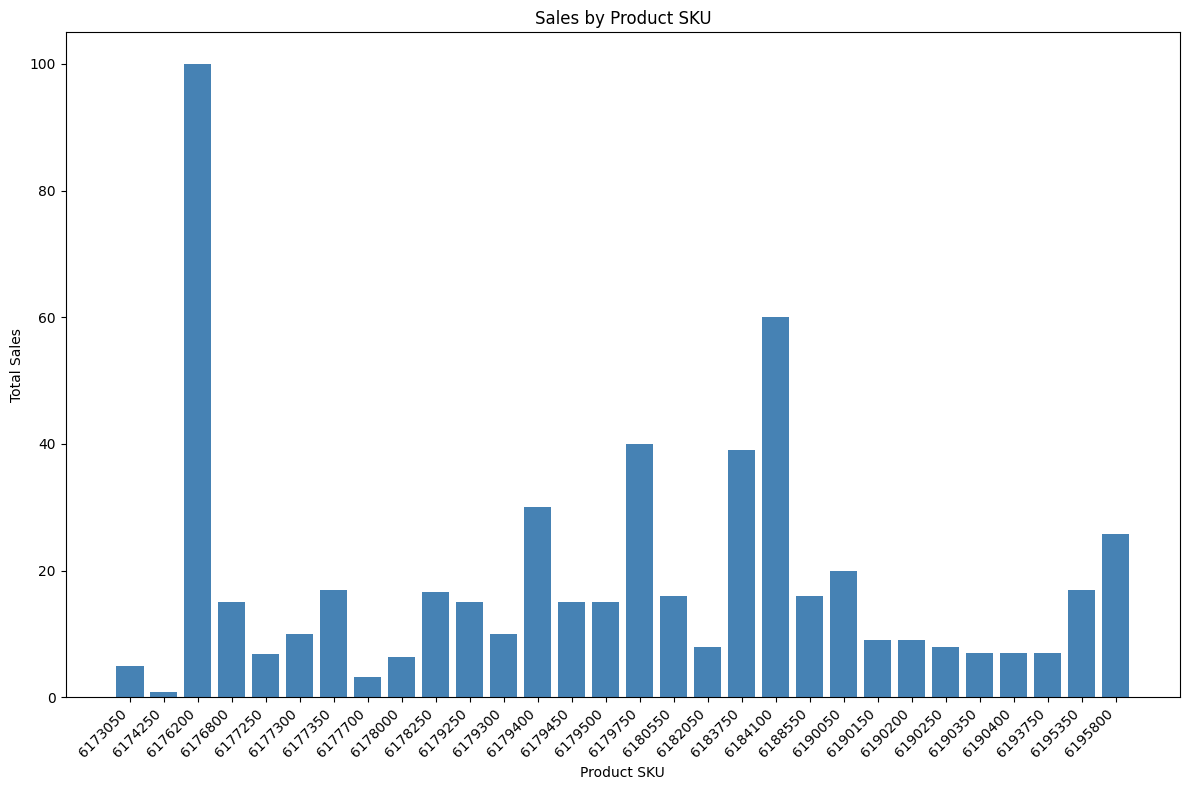

In [88]:
exec(final_message_content.replace('```python', '').replace('```', ''))

## <b><font color='darkblue'>Supplement</font></b>
* [**Gemini API** - ReAct agent from scratch with Gemini 2.5 and LangGraph](https://ai.google.dev/gemini-api/docs/langgraph-example)
* [**03-basic-langchain-agent:** Intro to LangChain Agents with Semantic Router](https://colab.research.google.com/github/aurelio-labs/semantic-router/blob/main/docs/03-basic-langchain-agent.ipynb)
* [**LangChain doc - How to return structured data from a model:** It is often useful to have a model return output that matches a specific schema.](https://python.langchain.com/docs/how_to/structured_output/)